In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import datetime
import json
import tensorflow as tf
from tqdm.keras import TqdmCallback

try: # are we in Colab?
    import google.colab
    COMPUTE_ENV = 'colab'
    print('Running in Colab.')
    google.colab.drive.mount('/content/gdrive')
    OUTPUT_DIR = "/content/gdrive/My Drive/output"
    !git clone https://github.com/FriedChips/dl_basics.git
    sys.path.insert(0,'/content/dl_basics')
except: # if not...
    if "kaggle" in os.environ["PWD"]: # are we in Kaggle?
        COMPUTE_ENV = 'kaggle'
        print('Running in Kaggle.')
        !git clone https://github.com/FriedChips/dl_basics.git
        sys.path.insert(0,'../working/dl_basics')    
        OUTPUT_DIR = "./"
    else: # we're local
        COMPUTE_ENV = os.uname()[1]
        print(f"Running locally on {COMPUTE_ENV}.")
        sys.path.insert(0,'./../')
        OUTPUT_DIR = "../output/"

for gpu in tf.config.list_physical_devices("GPU"):
    print(f"Found GPU: {tf.config.experimental.get_device_details(gpu)['device_name']}.")

Running in Colab.
Mounted at /content/gdrive
Cloning into 'dl_basics'...
remote: Enumerating objects: 463, done.
remote: Counting objects: 100% (178/178), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 463 (delta 90), reused 92 (delta 42), pack-reused 285
Receiving objects: 100% (463/463), 25.21 MiB | 10.11 MiB/s, done.
Resolving deltas: 100% (223/223), done.
Found GPU: Tesla T4.


In [2]:
from data_gen.modulo_arithmetic import addition_modulo_data
#import models
import utils

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Embedding, Dense, Conv2D, Flatten
from tensorflow.keras.regularizers import L2
from models.transformers import transformer_block

In [3]:
def build_model(
        model_name,
        seq_len,
        vocab_size,
        embed_dim,
        mlp_dim,
        regularizer = None,
        use_bias = False,
        lambda_emb_loss = 0,
):
    assert model_name in ["modulo_add_mlp_A", "modulo_add_mlp_B"]

    if regularizer is not None:
        regularizer = eval(regularizer)

    embed = Embedding(vocab_size, embed_dim, input_length=seq_len, embeddings_regularizer=regularizer, name="embedding")
    unemb = Dense(vocab_size, use_bias=use_bias, kernel_regularizer=regularizer, name="unembedding")

    inp = Input(shape=(seq_len,), dtype=np.int32, name="input")
    x = embed(inp)
    if model_name == "modulo_add_mlp_A":
        x = Dense(mlp_dim, use_bias=use_bias, kernel_regularizer=regularizer, name="mlp_1")(x)
        x = tf.math.reduce_sum(x, axis=-2)
    elif model_name == "modulo_add_mlp_B":
        x = tf.expand_dims(x, -1)
        x = Conv2D(mlp_dim, kernel_size=(seq_len, embed_dim), use_bias=use_bias, kernel_regularizer=regularizer, name="mlp_1")(x)
        x = Flatten()(x)
    x = tf.nn.relu(x)
    #x = Dense(embed_dim, use_bias=use_bias, kernel_regularizer=regularizer, name="mlp_2")(x)
    x = unemb(x)
    #x = tf.matmul(x, tf.transpose(embed.weights[0]))
    out = x
    
    model = Model(inp, out, name=model_name)

    #emb_loss = lambda: lambda_emb_loss * tf.reduce_sum(tf.square(embed.weights[0] - tf.transpose(unemb.weights[0])))
    #model.add_loss(emb_loss)

    return model


def transf_mod_arith(
        seq_len,
        vocab_size,
        embed_dim,
        use_bias=False,
):
    inp = Input(shape=(seq_len,), dtype=np.int32, name="input")
    x = Embedding(vocab_size, embed_dim, input_length=seq_len, name="embedding")(inp)
    x = transformer_block(x, num_heads=1, use_mlp=True, mlp_factor=1, use_bias=use_bias)
    x = Dense(vocab_size, use_bias=use_bias, name="unembedding")(x)
    out = x[..., -1, :]

    model = Model(inp, out, name="transf_mod_arith")
    return model

In [4]:
P = {}

P["addition_modulo_data"] = {
    "p_max" : 113,
    "train_size" : 0.3,
    "add_equal_sign" : False,
    "seed" : 42,
}

x_train, x_val, y_train, y_val = addition_modulo_data(**P["addition_modulo_data"])
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)
print(x_train.dtype, x_val.dtype, y_train.dtype, y_val.dtype)
print(x_train[0], y_train[0])

(3830, 2) (8939, 2) (3830,) (8939,)
int32 int32 int32 int32
[24 37] 61


In [6]:
# init new run

P["model_name"] = "modulo_add_mlp_A"
P["model_build_params"] = {
    "seq_len" : 2,
    "vocab_size" : P["addition_modulo_data"]["p_max"],
    "embed_dim" : 128,
    "mlp_dim" : 128,
    "regularizer" : None,
    "use_bias" : False,
    "lambda_emb_loss" : 0.0,
}

P["random_seed"] = 42
utils.tf_keras_random_seed(P["random_seed"])

model = build_model(P["model_name"], **P["model_build_params"])
model.summary()

P["loss"] = "SparseCategoricalCrossentropy(from_logits=True)"
P["optimizer"] = "AdamW(1e-3, weight_decay=1)"
#P["optimizer"] = "SGD(1e-0, momentum=0.9)"
P["metrics"] = [ "accuracy" ]
model.compile(loss = eval(P["loss"]), optimizer = eval(P["optimizer"]), metrics = P["metrics"])

P["run_dir"] = model.name + datetime.datetime.now().strftime('-%y%m%d-%H%M%S')
LOG_DIR = os.path.join(OUTPUT_DIR, P["run_dir"])

print("Log dir :", LOG_DIR)

run = utils.TrainingRun()
weight_norm_logger = utils.LogWeightNorms()
#weight_logger = utils.SaveWeightsPower2(LOG_DIR, 2**3)

Model: "modulo_add_mlp_A"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2)]               0         
                                                                 
 embedding (Embedding)       (None, 2, 128)            14464     
                                                                 
 tf.math.reduce_sum (TFOpLam  (None, 128)              0         
 bda)                                                            
                                                                 
 tf.nn.relu (TFOpLambda)     (None, 128)               0         
                                                                 
 unembedding (Dense)         (None, 113)               14464     
                                                                 
Total params: 28,928
Trainable params: 28,928
Non-trainable params: 0
______________________________________________

In [7]:
NUM_EPOCHS = 1024 * 2

history = model.fit(
    x_train, y_train,
    initial_epoch = run.current_epoch,
    epochs = run.current_epoch + NUM_EPOCHS,
    #batch_size = len(x_train) // 10,
    batch_size = 128,
    validation_data = (x_val, y_val),
    callbacks=[
        TqdmCallback(verbose=0),
        weight_norm_logger,
        #weight_logger,
    ],        
    verbose=0)

run.update_history(history)

0epoch [00:00, ?epoch/s]

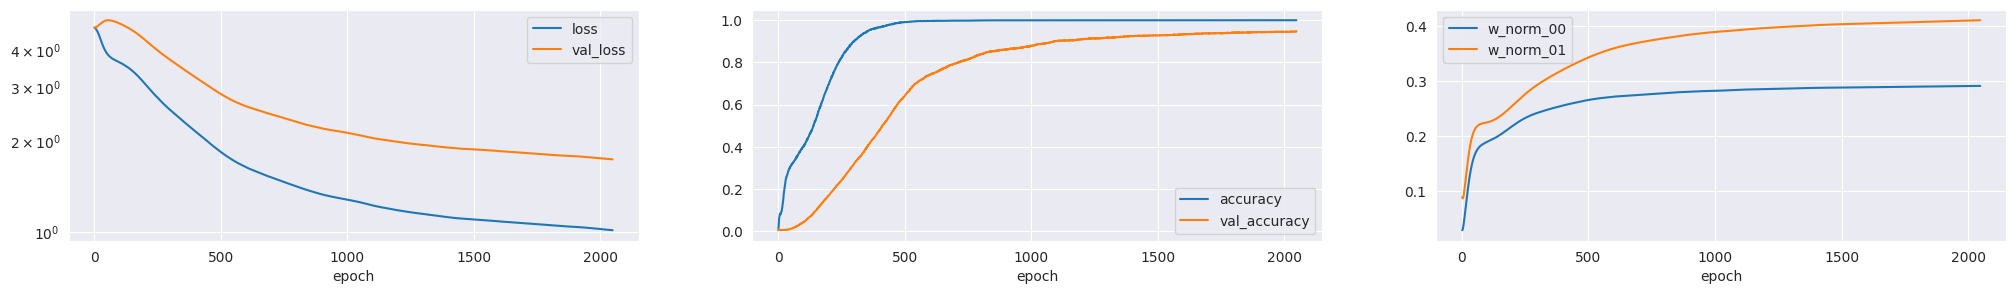

In [8]:
with sns.axes_style("darkgrid"):
    fig, axs = plt.subplots(1, 3, figsize=(25,3))
    sns.lineplot(data=run.history[["loss", "val_loss"]], ax=axs[0], dashes=False);
    axs[0].set_yscale("log");
    sns.lineplot(data=run.history[["accuracy", "val_accuracy"]], ax=axs[1], dashes=False);
    sns.lineplot(data=weight_norm_logger.norms_dataframe(), ax=axs[2], dashes=False);

In [9]:
run.save_state(LOG_DIR, P, model)
weight_norm_logger.norms_to_csv(LOG_DIR)